In [22]:
%matplotlib inline

In [178]:
import datetime
import numpy as np
import pylab
import eqcatalog
import eqcatalog.omori as omori
from ipy_render_html import render_html

In [250]:
reload(eqcatalog)
reload(omori)

Please upgrade to version 1.11.0 or higher


<module 'eqcatalog.omori' from 'C:\Users\Kris\Documents\Python\seismo\eqcatalog\omori.pyc'>

In [37]:
cat = eqcatalog.rob.query_local_eq_catalog(start_date=datetime.date(1992,1,1),
                                           end_date=datetime.date(1992,12,31))

In [225]:
dc_method = eqcatalog.declustering.ClusterMethod()
#dc_window = eqcatalog.declustering.Gruenthal2009Window()
dc_window = eqcatalog.declustering.GardnerKnopoff1974Window()
Mrelation = {'ML': 'Ahorner1983'}

In [226]:
mainshock = cat.get_event_by_id(987)

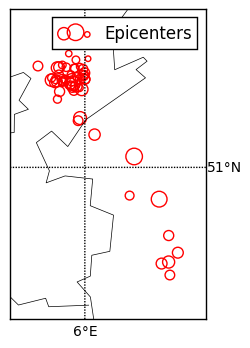

In [227]:
aftershocks = dc_method.get_aftershocks(mainshock, cat, dc_window, Mrelation)
aftershocks.plot_map()

In [228]:
aftershocks.print_info()

+-------------------+------------------------------+
|     Parameter     |            Value             |
+-------------------+------------------------------+
|    Catalog name   |                              |
| Earthquake number |              56              |
|     Start time    | 1992-04-13T03:22:53.000+0200 |
|      End time     | 1992-11-04T04:56:01.000+0100 |
|  Longitude bounds |       5.8688 / 6.2603        |
|  Latitude bounds  |      50.8100 / 51.2000       |
|    Depth range    |        8.0 / 24.0 km         |
|         ML        |    n=56, min=1.2, max=3.9    |
|    Event types    |          ke (n=56)           |
+-------------------+------------------------------+


In [229]:
render_html(aftershocks.print_list(as_html=True))

ID,Date,Time,Name,Lon,Lat,Z,ML
3596,1992-04-13,01:22:53,UETTERATH (DE),6.138,51.019,24.0,3.9
988,1992-04-13,01:31:08,ROERMOND (NL),5.927,51.163,15.6,2.1
989,1992-04-13,01:33:32,ROERMOND (NL),5.921,51.151,15.7,2.5
990,1992-04-13,01:46:03,ROERMOND(N),5.972,51.143,17.6,1.9
991,1992-04-13,01:53:30,ROERMOND(N),5.937,51.180,14.6,1.7
992,1992-04-13,02:02:24,ROERMOND(N),5.938,51.151,15.2,2.0
993,1992-04-13,02:04:31,ROERMOND(N),5.923,51.120,18.3,1.8
994,1992-04-13,02:05:07,MONTFORT(N),5.981,51.082,17.8,2.2
995,1992-04-13,02:08:20,ROERMOND(N),5.937,51.154,15.0,2.4
996,1992-04-13,02:30:40,ROERMOND(N),5.946,51.154,14.8,2.0


Determine cutoff magnitude

In [230]:
aftershocks.plot_Mhistogram(1.2, 4.0, 0.2, Mtype='ML', Mrelation={})

ImportError: No module named openquake.hazardlib

Fit aftershock rate

In [238]:
time_delta = np.timedelta64(12, 'h')
start_date = mainshock.datetime
elapsed_time = aftershocks.start_date - mainshock.datetime
elapsed_time_delta = elapsed_time/time_delta
#elapsed_time_delta = eqcatalog.time_functions.fractional_time_delta(elapsed_time, 'D')
print(elapsed_time_delta)
end_date = mainshock.datetime + np.timedelta64(1, 'M').astype('m8[s]')
observed_rate, bins_times = aftershocks.bin_by_time_interval(start_date, end_date, time_delta)
delta_t1 = np.arange(len(bins_times)) + 0.5
print(observed_rate)

0.00395833333333
[ 27.   6.   4.   1.   0.   0.   0.   2.   1.   1.   0.   0.   0.   0.   3.
   1.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


In [246]:
popt, perr = omori.OmoriLaw.fit_rate(delta_t1, observed_rate, initial_guess=(1,0.01, 1.2))
K, c, p = popt
print(K, c, p)
print(perr)

(11.112114651642708, 0.036984199674439375, 1.4281993224037899)
[ 3.6478581   0.17758693  0.23865319]


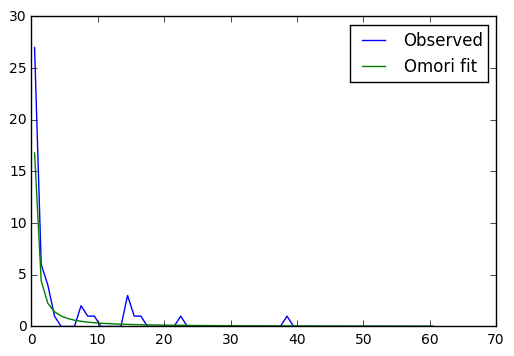

In [256]:
mol = omori.OmoriLaw(K, c, p, 1.0)
pylab.plot(delta_t1, observed_rate, label='Observed')
predicted_rate = mol.get_aftershock_rate(delta_t1)
pylab.plot(delta_t1, predicted_rate, label='Omori fit')
pylab.legend()
pylab.show()

In [257]:
mol.get_num_aftershocks(0.5)

23.416055927737506

Fit cumulative number of aftershocks

In [251]:
time_delta = np.timedelta64(12, 'h').astype('m8[s]')
aftershock_dts = aftershocks.get_datetimes()
delta_t2 = (aftershock_dts - mainshock.datetime) / time_delta
observed_N = np.arange(1, len(aftershocks)+1)
end_date = mainshock.datetime + np.timedelta64(7, 'D').astype('m8[s]')
delta_t2, observed_N = delta_t2[aftershock_dts < end_date], observed_N[aftershock_dts < end_date]
popt, perr = omori.OmoriLaw.fit_cumulative(delta_t2, observed_N, initial_guess=(1, 0.01, 1.2))
K, c, p = popt
print(K, c, p)
print(perr)

(8.7683500891026362, 0.13092778778475614, 1.4108368062615351)
[ 0.65702853  0.03605948  0.1156491 ]


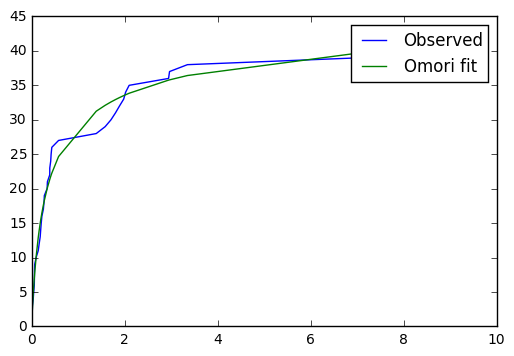

In [252]:
mol = omori.OmoriLaw(K, c, p, 1.0)
pylab.plot(delta_t2, observed_N, label='Observed')
predicted_N = mol.get_num_aftershocks(delta_t2)
pylab.plot(delta_t2, predicted_N, label='Omori fit')
pylab.legend()
pylab.show()

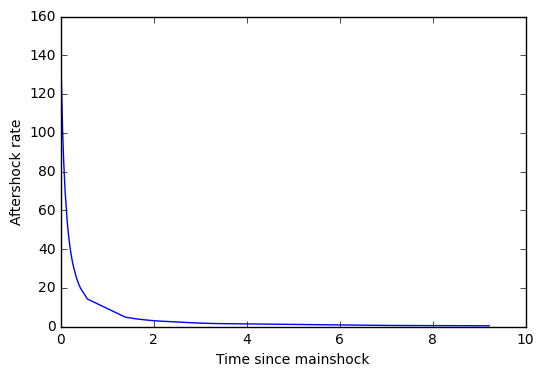

In [255]:
mol.plot_rate(delta_t2)

Papers:
https://aees.org.au/wp-content/uploads/2015/06/4-Ghasemi-Hadi-Afterschock.pdf
http://www1.rcep.dpri.kyoto-u.ac.jp/~benescu/Work/Nanjo_et_al_JGR_2007.pdf